In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline

import sys
sys.path.append('..')
from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks_v2 import *
from helper.orderbook_trader import *
from helper.RL_Agent import RLAgent

# Neural Network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
filename_train = '/home/axel/data/small/obs_2016-11_USDT_BTC_maxVol100.dict'
V = 100
vol_intervals = 10
T = 4
P = 15
state_variables=['volume','time']


actions = list(np.linspace(-0.4, 1.0, num=5))
print("V={}, T={}, P={}".format(V, T, P))
print("Actions: ", ", ".join(["{:1.2f}".format(a) for a in actions]))

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))

V=100, T=4, P=15
Actions:  -0.40, -0.05, 0.30, 0.65, 1.00
Length of episodes_train: 541


In [3]:
cached_episodes = list(episodes_train[:5])

### Settings

In [4]:
STATE_DIM = len(state_variables)
NUM_ACTIONS = len(actions)
print(STATE_DIM)
print(NUM_ACTIONS)

2
5


In [53]:
def base_model(input_dim=2, output_dim=15):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu', init='zero'))
    model.add(Dense(output_dim, activation='linear', init='zero'))
    model.compile(loss='mse', optimizer='Adam')
    return model

In [62]:
def train_RL(orderbooks, V, T, period_length, epochs, model=None, gamma=0.95, DECAY_RATE=0.005, epsilon=1.,
             bufferSize=50, batchSize=10, verbose=False, state_variables=['volume', 'time']):
    
    brain = RLAgent(actions=actions, state_variables=state_variables, V=V, T=T, period_length=period_length)

    state_dim = len(state_variables)    
    model = model or base_model(input_dim=state_dim, output_dim=NUM_ACTIONS)
    
    MAX_EXPLORATION_RATE = 1.
    MIN_EXPLORATION_RATE = 0.05

    replay = Memory(bufferSize)
    # stores tuples of (S, A, R, S')
    
    import warnings

    for i_window, window in tqdm(enumerate(orderbooks)):
        ots = OrderbookTradingSimulator(orderbooks=window, volume=V, tradingperiods=T,
                                                        period_length=P)
        
        for e in range(epochs):
            volume = V
            startpoint = 0
            
            if random.random() < 0.5:
                # randomly start at other states in environment
                volume = random.randint(1, V)
                startpoint = random.randint(0, T-1)
                # print("random - V:{}, T:{}".format(volume, startpoint))
            
            ots.reset(custom_starttime=startpoint, custom_startvolume=volume)
            
            action_history = []

            acc_cost = 0
            for step in range(startpoint, T):
                time_left = T - step
                timepoint = step*period_length
                timepoint_next = min((step+1)*period_length, len(window)-1)
                
                ob_now = window[timepoint]
                ob_next = window[timepoint_next]
                
                state = brain.generate_state(time_left=time_left,
                                         volume_left=volume,
                                         orderbook=ob_now)
                
                qval = model.predict(state.reshape(1, state_dim))

                if random.random() < epsilon:
                    # choose random action
                    action = random.choice(actions)
                else:
                    # choose best action from Q(s,a) values
                    action = actions[np.argmin(qval)]
                action_history.append(action)

                limit = ob_now.get_ask() * (1. + (action/100.))
                summary = ots.trade(limit=limit, verbose=False, extrainfo={'ACTION':action})  #agression_factor=action

                volume = float(ots.volume)

                new_state = brain.generate_state(time_left=time_left,
                                                 volume_left=volume,
                                                 orderbook=ob_next)

                cost = ots.history.cost.values[-1]

                acc_cost += cost
                
                if verbose:
                    print("{} {:1.1f} {} {:1.4f} {:1.4f}".format(step, action, ots.volume, cost, acc_cost))

                if cost < 0:
                    print("{} {:1.2f} {:1.4f} {}".format(state, action, cost, new_state))

                replay.add((state, action, cost, new_state))
                if (replay.size() >= batchSize):
                    # wait for buffer to be filled, before getting started with training
                    minibatch = replay.get_random_samples(batchSize)           

                    X_train = []
                    y_train = []
                    for memory in minibatch:
                        state_m, action_m, cost_m, new_state_m = memory
                        

                        qval_old = model.predict(state_m.reshape(1, state_dim))               
                        #print(qval_old)
                        y = np.zeros((1, NUM_ACTIONS))
                        y[:] = qval_old[:]

                        qval_new_m = model.predict(new_state_m.reshape(1, state_dim), batch_size=1)
                        # display(qval_old)
                        
                        minQ = np.min(qval_new_m)
                        # print(cost_m, gamma, minQ)
                        update = cost_m + (gamma*minQ)
                        # print("update", update)
                        action_m_idx = brain.get_action_index(action_m)

                        y[0][action_m_idx] = update  # target output
                        # display(y)
                        X_train.append(state_m.reshape(state_dim,))
                        y_train.append(y.reshape(NUM_ACTIONS,))
                        
                    X_train = np.array(X_train)
                    y_train = np.array(y_train)
                    # display(X_train)
                    # display(y_train)
                    # return
                    if verbose:
                        print("Game #: %s" % (i_window,))
                    model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
                state = new_state
                if summary['done']:
                    # display(ots.history)
                    break

            # reduce exploration rate
            if epsilon > MIN_EXPLORATION_RATE:
                epsilon = MAX_EXPLORATION_RATE *   math.exp(- DECAY_RATE * i_window)

            info = "   {} - {:4d}/{}: epsilon={:5.3f}, acc_cost: {:0.5f}, steps: {} (t={})\n"\
                    .format(e, i_window+1, epochs, epsilon,  acc_cost, step, ots.t)
            #print(info)
    return brain

In [ ]:
episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)

1it [00:08,  8.43s/it]


T 1
[ 0.1  1. ]
[ 0.2  1. ]
t1, v20  [[-0.02084386  0.25190914 -0.12695077 -0.12803978 -0.2009255 ]]
[ 0.3  1. ]
[ 0.4  1. ]
[ 0.5  1. ]
[ 0.6  1. ]
[ 0.7  1. ]
[ 0.8  1. ]
[ 0.9  1. ]
[ 1.  1.]
t1, v100 [[-0.1366449   0.25495631 -0.09740876 -0.1706205   0.03665512]]


,action,q,state,time,volume
"10.00,1",1.00,-0.226405,[ 0.1 1. ],1.0,10.0
"20.00,1",1.00,-0.200925,[ 0.2 1. ],1.0,20.0
"30.00,1",1.00,-0.169633,[ 0.3 1. ],1.0,30.0
"40.00,1",1.00,-0.137744,[ 0.4 1. ],1.0,40.0
"50.00,1",0.65,-0.138367,[ 0.5 1. ],1.0,50.0
"60.00,1",0.65,-0.141372,[ 0.6 1. ],1.0,60.0
"70.00,1",0.65,-0.146856,[ 0.7 1. ],1.0,70.0
"80.00,1",0.65,-0.158788,[ 0.8 1. ],1.0,80.0
"90.00,1",0.65,-0.164704,[ 0.9 1. ],1.0,90.0
"100.00,1",0.65,-0.170621,[ 1. 1.],1.0,100.0


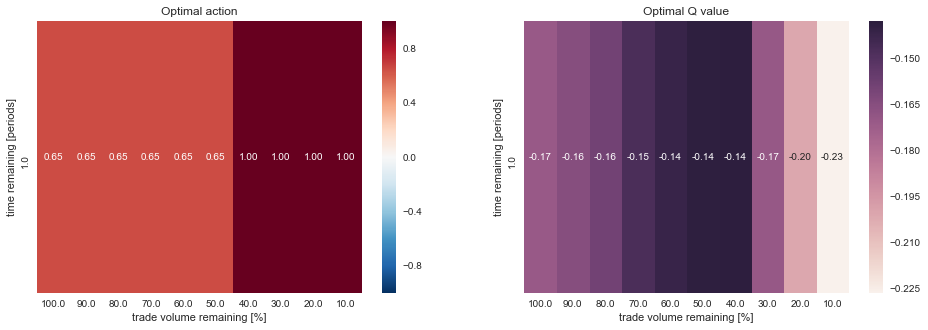

In [64]:
V=100
T=1
P=5

# plot_episode(episodes_train[1], volume=100)
agent = train_RL(orderbooks=episodes_train[1:2], V=V, T=T, period_length=P, epochs=50, model=None,
                 verbose=False, state_variables=['volume', 'time'])
agent.heatmap_Q()

In [65]:
actions

[-0.40000000000000002,
 -0.050000000000000044,
 0.29999999999999993,
 0.6499999999999998,
 1.0]

T 4
[ 0.1   0.25]
[ 0.2   0.25]
t1, v20  [[ 0.12015766 -0.04280229  0.06035274 -0.01766774 -0.0667851 ]]
[ 0.3   0.25]
[ 0.4   0.25]
[ 0.5   0.25]
[ 0.6   0.25]
[ 0.7   0.25]
[ 0.8   0.25]
[ 0.9   0.25]
[ 1.    0.25]
t1, v100 [[ 0.41223577 -0.15402411  0.01977972  0.10182758 -0.1557788 ]]
[ 0.1  0.5]
[ 0.2  0.5]
[ 0.3  0.5]
[ 0.4  0.5]
[ 0.5  0.5]
[ 0.6  0.5]
[ 0.7  0.5]
[ 0.8  0.5]
[ 0.9  0.5]
[ 1.   0.5]
[ 0.1   0.75]
[ 0.2   0.75]
[ 0.3   0.75]
[ 0.4   0.75]
[ 0.5   0.75]
[ 0.6   0.75]
[ 0.7   0.75]
[ 0.8   0.75]
[ 0.9   0.75]
[ 1.    0.75]
[ 0.1  1. ]
[ 0.2  1. ]
[ 0.3  1. ]
[ 0.4  1. ]
[ 0.5  1. ]
[ 0.6  1. ]
[ 0.7  1. ]
[ 0.8  1. ]
[ 0.9  1. ]
[ 1.  1.]


,action,q,state,time,volume
"10.00,1",1.0,-0.054812,[ 0.1 0.25],1.0,10.0
"20.00,1",1.0,-0.066785,[ 0.2 0.25],1.0,20.0
"30.00,1",1.0,-0.079094,[ 0.3 0.25],1.0,30.0
"40.00,1",1.0,-0.088688,[ 0.4 0.25],1.0,40.0
"50.00,1",1.0,-0.099447,[ 0.5 0.25],1.0,50.0
"60.00,1",1.0,-0.110812,[ 0.6 0.25],1.0,60.0
"70.00,1",1.0,-0.121762,[ 0.7 0.25],1.0,70.0
"80.00,1",1.0,-0.133550,[ 0.8 0.25],1.0,80.0
"90.00,1",1.0,-0.144695,[ 0.9 0.25],1.0,90.0
"100.00,1",1.0,-0.155779,[ 1. 0.25],1.0,100.0


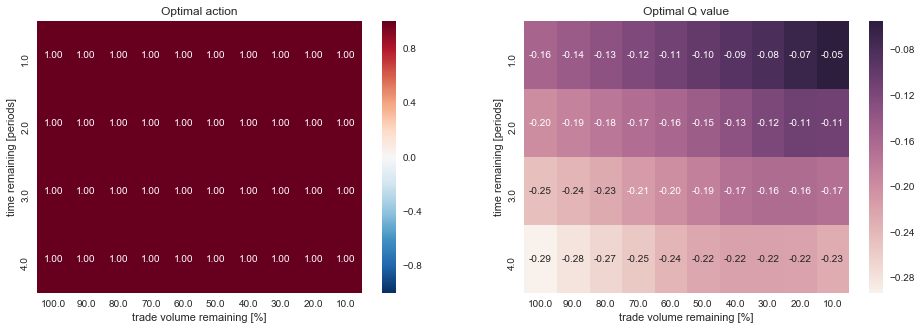

In [34]:
agent.heatmap_Q()

In [ ]:
heatmap_Q(model=model, vol_intervals=vol_intervals, T=T)
plot_Q(model=model, z_represents='action', state_variables=['volume', 'time'])
plot_Q(model=model, z_represents='Q', state_variables=['volume', 'time'])

In [ ]:
def run(V, T, P, epochs=1, overwrite_actions=None):
    for i_episode in range(epochs):
        ots = OrderbookTradingSimulator(orderbooks=episode_windows[1], volume=V,
                                        tradingperiods=T, period_length=P)
        plot_episode(episode_windows[1], volume=V)
        time_left = P*T
        volume = V

        state = np.array([time_left, volume])  # , volume])
        # state = discretize_state(state)

        acc_cost = 0
        for step in range(T):
            qval = model.predict(state.reshape(1, STATE_DIM))
            
            action = actions[np.argmin(qval)]
            
            if overwrite_actions and step < len(overwrite_actions):
                action = overwrite_actions[step]

            # info = ots.trade(orderbooks, limit=lim, verbose=False)
            info = ots.trade(agression_factor=action, verbose=False, extrainfo={'ACTION':action})

            time_left -= 1
            volume = ots.volume
            new_state = np.array([time_left, volume])  # , volume])
            cost = ots.history.cost.values[-1]

            acc_cost += cost

            state = new_state
            if volume == 0:
                break

        info = "{:4d}/{}: acc_cost: {:0.5f}, steps: {} (t={})"\
                .format(i_episode+1, epochs, acc_cost, step, ots.t)
        print(info)
    return ots.history
hist = run(V=V, T=T, P=P)  #, overwrite_actions=[0,0,0,0,0,0,0,0,0])
display(hist)
hist = run(V=V, T=T, P=P, overwrite_actions=[0.7]*10)
display(hist)
hist = run(V=V, T=T, P=P, overwrite_actions=[0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8])
display(hist)